In [354]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Gaussian Process Regression

## Mathematical Foundations

A Gaussian Process (GP) is defined as a collection of random variables, any finite number of which have a joint Gaussian distribution. It is completely specified by its mean function $m(x)$ and covariance function $k(x, x')$:

$f(x) \sim \mathcal{GP}(m(x), k(x, x'))$

where:
- $m(x)$ is the mean function (often assumed to be 0)
- $k(x, x')$ is the kernel function defining the covariance

One of the more commonly used kernels ($k$) is the RBF kernel:

$k(x, x') = \sigma^2 \exp\left(-\frac{||x - x'||^2}{2l^2}\right)$

where:
- $\sigma^2$ is the variance parameter
- $l$ is the length scale parameter


Given training data $\mathcal{D} = \{(x_i, y_i)\}_{i=1}^n$, the posterior distribution at a new point $x_*$ is:

$p(f_* | x_*, \mathcal{D}) = \mathcal{N}(\mu_*, \sigma_*^2)$

where:

$\mu_* = k_*^T(K + \sigma_n^2I)^{-1}y$

$\sigma_*^2 = k_{**} - k_*^T(K + \sigma_n^2I)^{-1}k_*$

- $K$ is the kernel matrix between all training points
- $k_*$ is the kernel vector between $x_*$ and all training points
- $k_{**}$ is the kernel value between $x_*$ and itself
- $\sigma_n^2$ is the noise variance


# Using TinyGP

For the first part of this notebook we will be using TinyGP to allow us to interact with the Gaussian Processes at a lower level.

Make sure that you can run the following cell before continueing.

In [355]:
from tinygp import GaussianProcess
from tinygp import kernels
import jax
jax.config.update("jax_enable_x64", True)

A key part of Gaussian Process regression is the ability to work with differnt specialized kernels depending on the problem at hand. These kernels allow you to view the data from different perspectives to better understand it.

## Example Kernel Functions and Their Properties

### 1. Radial Basis Function (RBF) Kernel a.k.a Squared Exponential
$k_{RBF}(x, x') = \sigma^2 \exp\left(-\frac{||x - x'||^2}{2l^2}\right)$
- Infinitely differentiable
- Universal kernel
- Suitable for smooth functions

### 2. Matérn Kernel
$k_{Matern}(x, x') = \sigma^2\frac{2^{1-\nu}}{\Gamma(\nu)}\left(\sqrt{2\nu}\frac{||x-x'||}{l}\right)^\nu K_\nu\left(\sqrt{2\nu}\frac{||x-x'||}{l}\right)$
- Controls smoothness through parameter $\nu$
- More realistic for physical processes

### 3. Periodic Kernel
$k_{Per}(x, x') = \sigma^2 \exp\left(-\frac{2\sin^2(\pi||x-x'||/p)}{l^2}\right)$
- Captures periodic patterns
- Useful for seasonal data

### 4. Cosine Kernel
$k_{cos}(x,x') = \cos (2 \pi r)$


Below are the plots of a few of these kernels.

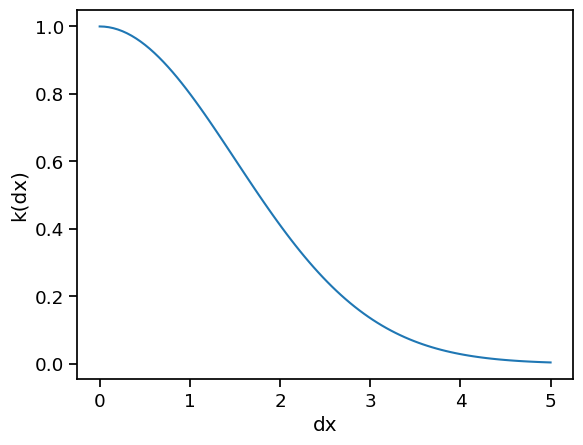

In [356]:
def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 5, 100)
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")

kernel = kernels.ExpSquared(scale=1.5)
plot_kernel(kernel)

## Scaling Kernels

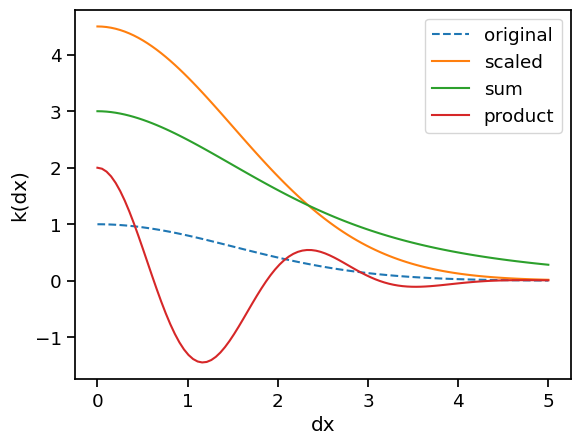

In [357]:
plot_kernel(kernel, label="original", ls="dashed")

kernel_scaled = 4.5 * kernels.ExpSquared(scale=1.5)
plot_kernel(kernel_scaled, label="scaled")

kernel_sum = kernels.ExpSquared(scale=1.5) + 2 * kernels.Matern32(scale=2.5)
plot_kernel(kernel_sum, label="sum")

kernel_prod = 2 * kernels.ExpSquared(scale=1.5) * kernels.Cosine(scale=2.5)
plot_kernel(kernel_prod, label="product")

_ = plt.legend()

## Visualizing Different Kernels

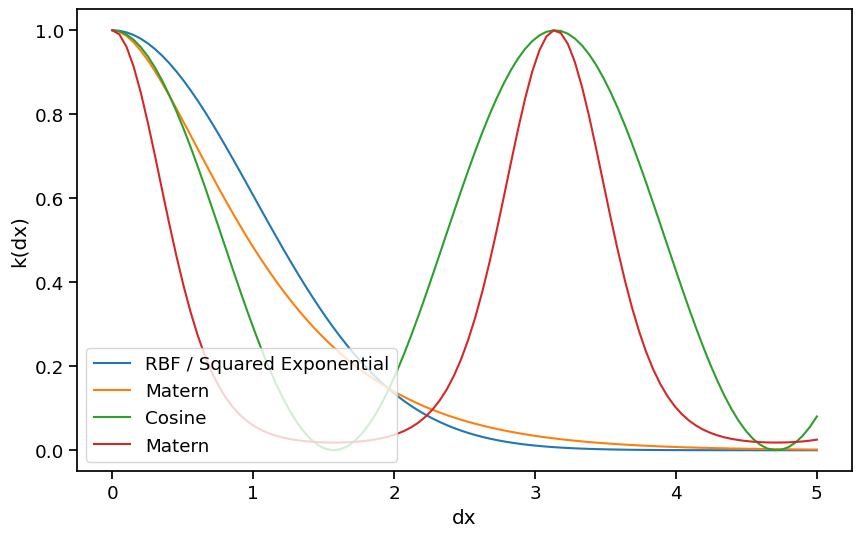

In [367]:
plt.figure(figsize=(10,6))

kernel_rbf = kernels.ExpSquared() # TODO: Squared Exponential
plot_kernel(kernel_rbf, label="RBF / Squared Exponential")

kernel_matern = kernels.Matern32() # TODO: Matern
plot_kernel(kernel_matern, label="Matern")

kernel_cosine =  .5 * kernels.Cosine(scale=np.pi) + .5 # TODO: Cosine (might have to scale this one to have it fit nicely)
plot_kernel(kernel_cosine, label="Cosine")

kernel_expsine = kernels.ExpSineSquared(gamma = 4, scale=np.pi) # TODO: Exponential Sin (play around with some of the parameters)
plot_kernel(kernel_expsine, label="Matern")

_ = plt.legend(loc = "lower left")
plt.show()

## A set of candidates

Like in many other situations we are trying to fit a function to a set of data. Without having ALL of the data there are infinite possibilities for what the potential function is that generated our data. Gaussian Processes do a good job of creating a confidence interval for the candidate functions.

In the cell below we create a sample dataset and plot some candidate functions using the squared exponential kernel.

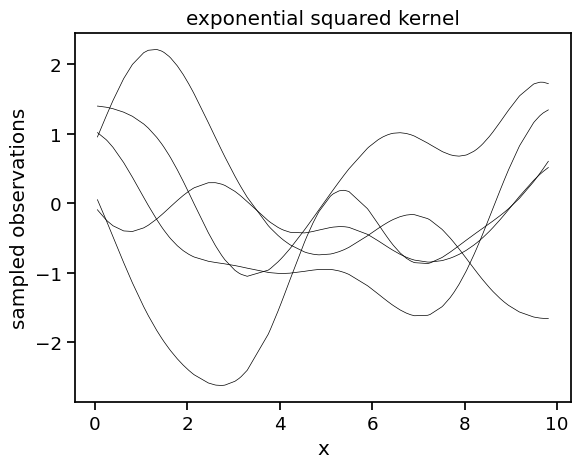

In [359]:
X = np.sort(np.random.default_rng(1).uniform(0, 10, 100))
gp = GaussianProcess(kernel, X)

y = gp.sample(jax.random.PRNGKey(4), shape=(5,))
plt.plot(X, y.T, color="k", lw=0.5)
plt.xlabel("x")
plt.ylabel("sampled observations")
_ = plt.title("exponential squared kernel")

### Combining Kernels

Another unique part of Gaussian Processes is that we can create custom easily by multiplying other kernels together. This allows us to be more flexible with our data.

In this cell create a custom kernel by multipling an `ExpSquared` with length scale 1.5 and a `Cosine` kernel with a scale of 2.5

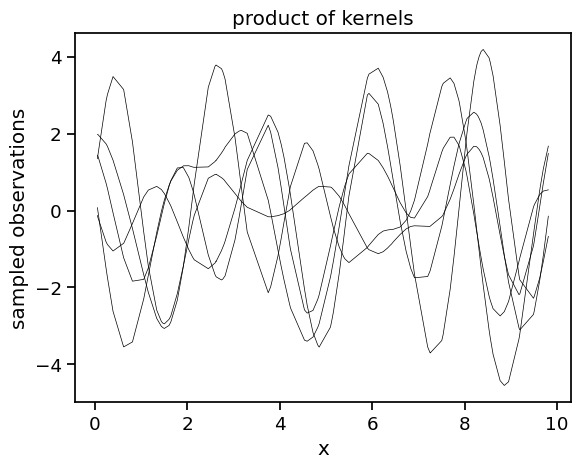

In [360]:
kernel_prod = 2 * kernels.ExpSquared(scale=1.5) * kernels.Cosine(scale=2.5) # TODO: Create a custom kernel through multiplication
gp = GaussianProcess(kernel_prod, X, diag=1e-5)
y = gp.sample(jax.random.PRNGKey(4), shape=(5,))

plt.plot(X, y.T, color="k", lw=0.5)
plt.xlabel("x")
plt.ylabel("sampled observations")
_ = plt.title("product of kernels")


### Finding the mean

Once we have all these potential candidates, we can take the mean of them to determine the actual function that was used to generate our data. 

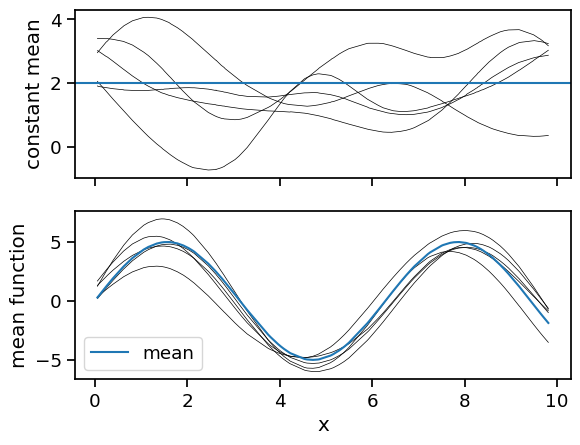

In [361]:
# A GP with a non-zero constant mean
gp = GaussianProcess(kernel, X, diag=1e-5, mean=2.0) # TODO: Define a GP with a constant mean
y_const = gp.sample(jax.random.PRNGKey(4), shape=(5,)) # TODO: Sample from the GP

# And a GP with a general mean function
def mean_function(x):
    return 5 * jax.numpy.sin(x)

gp = GaussianProcess(kernel, X, diag=1e-5, mean=mean_function) # TODO: Define a GP with a non-constant mean
y_func = gp.sample(jax.random.PRNGKey(4), shape=(5,)) # TODO: Sample

# Plotting these samples
_, axes = plt.subplots(2, 1, sharex=True)
ax = axes[0]
ax.plot(X, y_const.T, color="k", lw=0.5)
ax.axhline(2.0)
ax.set_ylabel("constant mean")

ax = axes[1]
ax.plot(X, y_func.T, color="k", lw=0.5)
ax.plot(X, jax.vmap(mean_function)(X), label="mean")
ax.legend()
ax.set_xlabel("x")
_ = ax.set_ylabel("mean function")

### The distribution of the candidate functions

Because we have created this distribution of candidate functions we can sample from it and calculate different relevant statistics. 


In [362]:
# Simulate a made up dataset, as an example
random = np.random.default_rng(1)
X = np.sort(random.uniform(0, 10, 10))
y = np.sin(X) + 1e-4 * random.normal(size=X.shape)

# Compute the log probability
kernel = 0.5 * kernels.ExpSquared(scale=1.0) # Define a kernel
gp = GaussianProcess(kernel, X, diag=1e-4) 
print(gp.log_probability(y))

0.16462032491346212


### Visualizing the whole thing

Below we visualize all these steps in one plot. You can see the confidence bounds of the distribution describing our candidate functions.

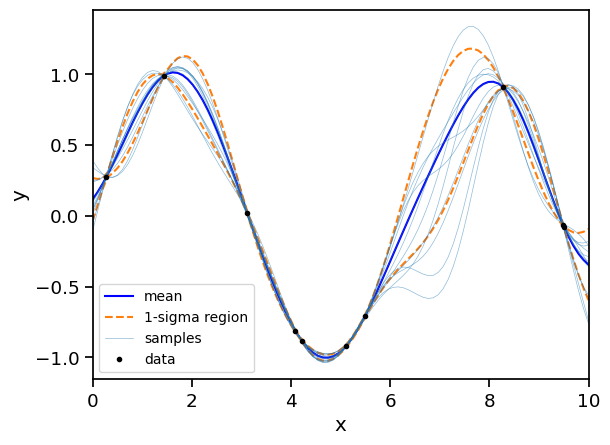

In [363]:
X_test = np.linspace(0, 10, 100)
_, cond_gp = gp.condition(y, X_test)

# The GP object keeps track of its mean and variance, which we can use for plotting confidence intervals

mu = cond_gp.mean # TODO: Extract mean from conditioned gp
std = np.sqrt(cond_gp.variance) # TODO Extract std

plt.plot(X_test, mu, "C1", color = "blue", label="mean")
plt.plot(X_test, mu + std, "--C1", label="1-sigma region")
plt.plot(X_test, mu - std, "--C1")

# We can also plot samples from the conditional
y_samp = cond_gp.sample(jax.random.PRNGKey(1), shape=(12,))
plt.plot(X_test, y_samp[0], "C0", lw=0.5, alpha=0.5, label="samples")
plt.plot(X_test, y_samp[1:].T, "C0", lw=0.5, alpha=0.5)

plt.plot(X, y, ".k", label="data")
plt.legend(fontsize=10)
plt.xlim(X_test.min(), X_test.max())
plt.xlabel("x")
_ = plt.ylabel("y")

## Gaussian Process Regression and real world science

Guassian process regression fits very well with the idea of efficient experimentation. You want to want to be able to gain as much possible information with as few trials as possible. To do this you need to be able to know what you don't know. A question that is usually very difficult to answer. With GPR, you are able to calculate your confidence intervals of the distribution of candidate functions that may fit your data. With this information you are able to perform experiments that maximize imformatian gain from trial to trial.

In the example below assume the true function is 
- $y = \sin(x) + \frac{1}{5}\cos(x)$

Additionally assume that in this experiement there is a sample noise:
- $\epsilon \sim N(0,\frac{1}{10})$

Then the sampled data would have a function of 
- $y = \sin(x) + \frac{1}{5}\cos(x) + \epsilon$


In [364]:

def generate_true_function(x):
    """Generate a nonlinear function for demonstration"""
    return np.sin(x) + 0.2 * np.cos(3*x) # TODO: True function

def generate_function_with_noise(x):
    return np.sin(x) + 0.2 * np.cos(3*x) + np.random.normal(loc = 0, scale = .1) # TODO: Sampling function

def plot_gpr_progression(X_train, y_train, kernel, x_test):
    """Plot GPR predictions with confidence intervals"""
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=42) # TODO: Instantiate GPR with kernel = kernel and random_state = 42
    gpr.fit(X_train, y_train) # TODO: Fit the GPR
    
    # Make predictions
    y_pred, sigma = gpr.predict(x_test.reshape(-1, 1), return_std=True) # TODO: Get y_pred and sigma (predictions and std) from gpr.predict
    
    # Plot true function
    plt.plot(x_test, generate_true_function(x_test), 'k--', label='True Function')
    
    # Plot training points
    plt.scatter(X_train, y_train, color='red', label='Training Points')
    
    # Plot prediction and confidence intervals
    plt.plot(x_test, y_pred, 'b-', label='GPR Prediction')
    plt.fill_between(x_test, y_pred - 2*sigma, y_pred + 2*sigma, 
                     color='blue', alpha=0.2, label='95% Confidence Interval')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title(f'GPR with {len(X_train)} Training Points')
    plt.grid(True)
    plt.show()

Plot the data with different numbers of observed data points and see how our distribution changes.

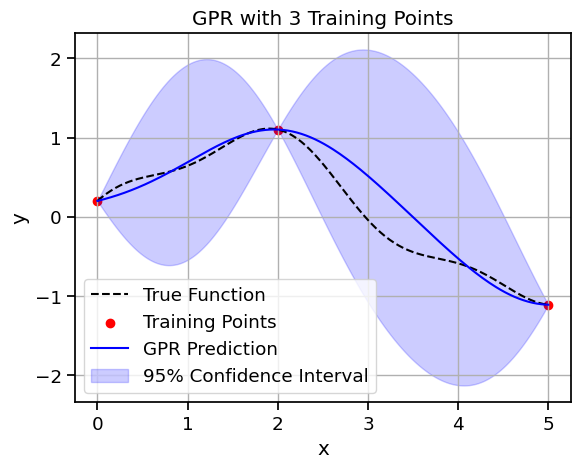

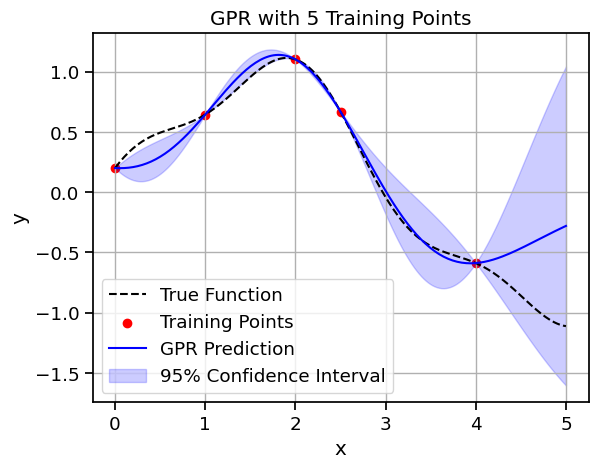

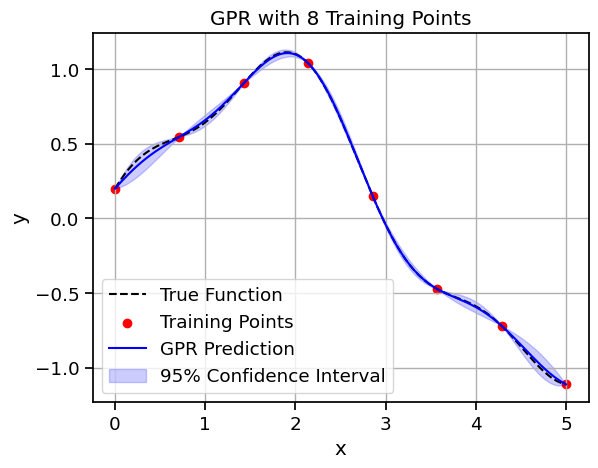

In [365]:
np.random.seed(42)

# Generate test points for smooth visualization
x_test = np.linspace(0, 5, 200)

# Define kernel 
kernel = RBF(length_scale=1.0) # TODO: Define Kernel

# Small training set
X_small = np.array([0.0, 2.0, 5.0]).reshape(-1, 1) # TODO: Define an array of 3 x-values within the range of x_test
y_small = generate_true_function(X_small)

# Medium training set
X_medium = np.array([0.0, 1.0, 2.0, 2.5, 4.0]).reshape(-1, 1) # TODO: Define an array of 5 x-values within the range of x_test
y_medium = generate_true_function(X_medium)

# Large training set
X_large = np.linspace(0, 5, 8).reshape(-1, 1) # TODO: Define an array of 8 x-values within the range of x_test
y_large = generate_true_function(X_large)

plot_gpr_progression(X_small, y_small, kernel, x_test)

plot_gpr_progression(X_medium, y_medium, kernel, x_test)

plot_gpr_progression(X_large, y_large, kernel, x_test)
